In [25]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split


# Polynmial regression model

In [26]:
class PolynomialRegression:
     
    def __init__(self, degree, learning_rate, iterations):
        self.degree = degree
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.W = None
        self.mean = None
        self.std = None

    # Function to transform X into polynomial features
    def transform(self, X):
        X_transform = np.ones((X.shape[0], 1))  # Add bias term (X^0)
        for j in range(1, self.degree + 1):
            X_transform = np.append(X_transform, np.power(X, j).reshape(-1, 1), axis=1)
        return X_transform

    # Function to normalize the features (save mean and std for normalization)
    def normalize(self, X):
        if self.mean is None or self.std is None:
            self.mean = np.mean(X[:, 1:], axis=0)  # Mean excluding the bias term
            self.std = np.std(X[:, 1:], axis=0)    # Standard deviation excluding the bias term
        X[:, 1:] = (X[:, 1:] - self.mean) / self.std
        return X

    # Model training using gradient descent
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.m, self.n = self.X.shape

        # Transform X into polynomial features
        X_transform = self.transform(self.X)

        # Normalize the transformed features
        X_normalize = self.normalize(X_transform)

        # Initialize weights - ensure it is a column by using reshape ()
        self.W = np.zeros(X_normalize.shape[1]).reshape(-1,1)

        print(f'model training: x_normalize shape:{X_normalize.shape}\nWeights shape: {self.W.shape}')
        # Gradient descent learning
        for i in range(self.iterations):
            h = self.predict(self.X)

            error = h - self.Y

            if i == 0:
                print(f'h shape:{h.shape} Self.y shape: {self.Y.shape} Error vector shape: {error.shape}')
            # Update weights
            self.W = self.W - self.learning_rate * (1 / self.m) * np.dot(X_normalize.T, error)

            if i == 0:
                print(f'weight shape:{self.W.shape}')

        return self

    # Predict function using the learned weights
    def predict(self, X):
        # Transform and normalize X for prediction
        X_transform = self.transform(X)
        X_normalize = self.normalize(X_transform)

        #ensure output is a column vector
        return np.dot(X_normalize, self.W).reshape(-1,1)
    

# Data loading and unifeature lag engineering

In [27]:
# Data loading
def data_loader(filepath):
    data = pd.read_csv(filepath)
    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')

    return data

#select one feature
def featureEngineering(data, n_past=1):
    X = []
    Y= []
    for i in range(n_past, len(data)):
        X.append(data.iloc[i-n_past:i, -2].values)  # Select n_past number of rows for the closing price
        Y.append(data.iloc[i, -2])  # The target value - closing

    feature_columns = [f'n_{i}' for i in range(1, n_past+1)]
    X_df = pd.DataFrame(X, columns=feature_columns)
    Y_df = pd.DataFrame(Y, columns=['response'])

    data = pd.concat([X_df, Y_df], axis=1)

    return data, X_df,Y_df

filepath = './Data/EURUSD_D1.csv' 
datasetX = data_loader(filepath)

print(datasetX.head())

laggedDataset, f_lag, response = featureEngineering(datasetX,1)


        Time     Open     High      Low    Close  Volume
0 2008-08-01  1.55575  1.55886  1.55142  1.55609  755330
1 2008-08-03  1.55638  1.55790  1.55586  1.55658   76728
2 2008-08-04  1.55662  1.56306  1.55526  1.55638  858293
3 2008-08-05  1.55624  1.55646  1.54442  1.54640  858740
4 2008-08-06  1.54650  1.55167  1.53956  1.54195  850798


# Polynomial forecastin

<class 'numpy.ndarray'>
model training: x_normalize shape:(4009, 7)
Weights shape: (7, 1)
h shape:(4009, 1) Self.y shape: (4009, 1) Error vector shape: (4009, 1)
weight shape:(7, 1)


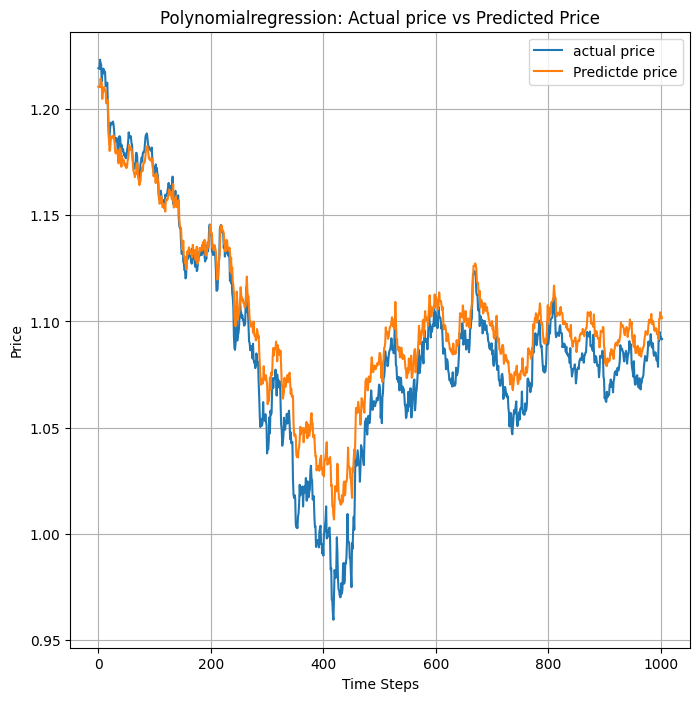

In [40]:
# train , test split
x_train, x_test, y_train, y_test = train_test_split(f_lag, response, test_size=0.2,random_state=12, shuffle=False)

print(type(x_train.values))

#create instance of model
degree = 6  # Quadratic polynomial
learning_rate = 0.01
iterations = 1000

modelPolReg = PolynomialRegression(degree, learning_rate, iterations)
modelPolReg.fit(x_train.values, y_train.values)

#make predictions
y_pred = modelPolReg.predict(x_test.values)

#convert to 1D /numpyarray for plotting
y_test = y_test.to_numpy()
y_pred = y_pred.flatten()

plt.figure(figsize=(14, 7))
plt.plot(y_test, label ='actual price')
plt.plot(y_pred, label='Predictde price')
plt.title('Polynomialregression: Actual price vs Predicted Price')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()